In [2]:
!pip install -q tensorflow matplotlib opencv-python scikit-learn kagglehub tqdm


In [3]:
import kagglehub
path = kagglehub.dataset_download("lorenzoarcioni/road-damage-dataset-potholes-cracks-and-manholes")
print("Base path:", path)


100%|██████████| 184M/184M [00:07<00:00, 26.9MB/s]

Extracting files...


Base path: /root/.cache/kagglehub/datasets/lorenzoarcioni/road-damage-dataset-potholes-cracks-and-manholes/versions/3


In [4]:
import os

dataset_path = "/root/.cache/kagglehub/datasets/lorenzoarcioni/road-damage-dataset-potholes-cracks-and-manholes/versions/3"

print("Using dataset_path:", dataset_path)
for root, dirs, files in os.walk(dataset_path):
    print(root, "->", len(dirs), "dirs,", len(files), "files")
    break

images_dir = os.path.join(dataset_path, "data", "images")
labels_dir = os.path.join(dataset_path, "data", "labels")

print("images_dir exists:", os.path.exists(images_dir))
print("labels_dir exists:", os.path.exists(labels_dir))


Using dataset_path: /root/.cache/kagglehub/datasets/lorenzoarcioni/road-damage-dataset-potholes-cracks-and-manholes/versions/3
/root/.cache/kagglehub/datasets/lorenzoarcioni/road-damage-dataset-potholes-cracks-and-manholes/versions/3 -> 1 dirs, 0 files
images_dir exists: True
labels_dir exists: True


In [5]:
import os, cv2, numpy as np
from tqdm import tqdm
from collections import Counter

IMG_SIZE = (128, 128)

images_dir = "/root/.cache/kagglehub/datasets/lorenzoarcioni/road-damage-dataset-potholes-cracks-and-manholes/versions/3/data/images"
labels_dir = "/root/.cache/kagglehub/datasets/lorenzoarcioni/road-damage-dataset-potholes-cracks-and-manholes/versions/3/data/labels"

image_files = sorted([
    f for f in os.listdir(images_dir)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
])

print("Total images found:", len(image_files))

images = []
labels = []
label_counts = Counter()
missing_labels = 0
unique_label_ids = set()

for f in tqdm(image_files, desc="Loading dataset"):
    img_path = os.path.join(images_dir, f)
    label_path = os.path.join(labels_dir, f.replace(".jpg", ".txt"))

    # Read image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)

    # Handle label (YOLO format)
    if os.path.exists(label_path):
        with open(label_path, "r") as lf:
            lines = [x.strip() for x in lf.readlines()]

        if len(lines) > 0:
            # Take first label (single-class classification)
            class_id = int(lines[0].split()[0])
            unique_label_ids.add(class_id)
            label_counts[class_id] += 1
        else:
            class_id = -1
            missing_labels += 1
    else:
        class_id = -1
        missing_labels += 1

    images.append(img)
    labels.append(class_id)

print("\nMissing/empty labels:", missing_labels)
print("Unique label IDs:", sorted(unique_label_ids))
print("Label distribution:", label_counts)


Total images found: 2009


Loading dataset: 100%|██████████| 2009/2009 [00:10<00:00, 199.46it/s]


Missing/empty labels: 0
Unique label IDs: [0, 1, 2]
Label distribution: Counter({1: 1002, 2: 541, 0: 466})


In [6]:
import numpy as np

# Confirm class names
class_id_to_name = {
    0: "pothole",
    1: "crack",
    2: "manhole"
}

print("Mapping:", class_id_to_name)

# Convert to numpy arrays (already includes everything)
X = np.array(images, dtype=np.float32) / 255.0
y = np.array(labels, dtype=np.int32)

# Final shapes
print("X shape:", X.shape)
print("y shape:", y.shape)


Mapping: {0: 'pothole', 1: 'crack', 2: 'manhole'}
X shape: (2009, 128, 128, 3)
y shape: (2009,)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

# Compute class weights to handle imbalance
classes = np.unique(y_train)
weights = compute_class_weight('balanced', classes=classes, y=y_train)

class_weight_dict = {int(c): float(w) for c, w in zip(classes, weights)}

print("Class Weights:", class_weight_dict)


Train size: (1607, 128, 128, 3)
Test size: (402, 128, 128, 3)
Class Weights: {0: 1.4361036639857014, 1: 0.6687473990844778, 2: 1.237105465742879}


In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

num_classes = 3
input_shape = (128, 128, 3)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.08,
    height_shift_range=0.08,
    horizontal_flip=True,
    zoom_range=0.1
)

train_gen = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)

# Callbacks
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
]

history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train)//32,
    validation_data=(X_test, y_test),
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,483,779 (32.36 MB)

 Trainable params: 8,483,331 (32.36 MB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.3552 - loss: 10.6579
Epoch 1: val_accuracy improved from -inf to 0.23134, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 263ms/step - accuracy: 0.3557 - loss: 10.5775 - val_accuracy: 0.2313 - val_loss: 7.6511 - learning_rate: 0.0010
Epoch 2/25
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3750 - loss: 1.0774
Epoch 2: val_accuracy did not improve from 0.23134
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3750 - loss: 1.0774 - val_accuracy: 0.2313 - val_loss: 7.8702 - learning_rate: 0.0010
Epoch 3/25


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2803 - loss: 1.6230
Epoch 3: val_accuracy improved from 0.23134 to 0.26866, saving model to best_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.2805 - loss: 1.6189 - val_accuracy: 0.2687 - val_loss: 20.4933 - learning_rate: 0.0010
Epoch 4/25
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.3438 - loss: 1.2763
Epoch 4: val_accuracy did not improve from 0.26866

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3438 - loss: 1.2763 - val_accuracy: 0.2687 - val_loss: 20.4672 - learning_rate: 0.0010
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3248 - loss: 1.1225
Epoch 5: val_accuracy did not improve from 0.26866
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.3247 - loss: 1.1222 - val_accuracy: 0.2687 - val_loss: 14.7000 - learning_rate: 5.0000e-04
Epoch 6/25
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.3750 - loss: 1.1862
Epoch 6: val_accuracy did not improve from 0.26866
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3750 - loss: 1.1862 - val_accurac

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2311 - loss: 7.5332
Test Accuracy: 23.13%
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


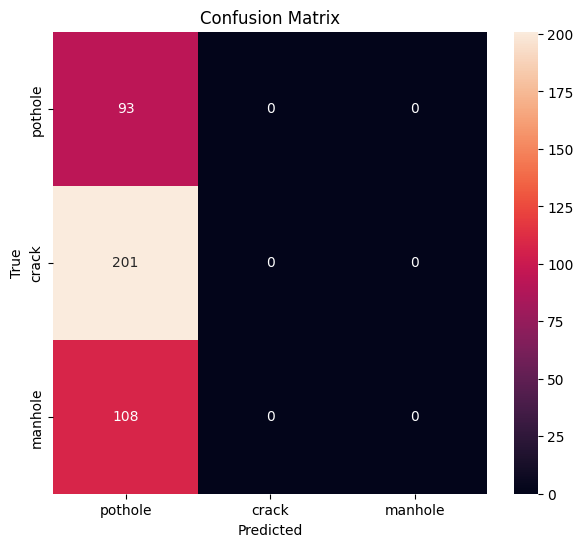

              precision    recall  f1-score   support

     pothole       0.23      1.00      0.38        93
       crack       0.00      0.00      0.00       201
     manhole       0.00      0.00      0.00       108

    accuracy                           0.23       402
   macro avg       0.08      0.33      0.13       402
weighted avg       0.05      0.23      0.09       402



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [9]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

# Predictions
y_pred = np.argmax(model.predict(X_test), axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    xticklabels=[class_id_to_name[i] for i in range(3)],
    yticklabels=[class_id_to_name[i] for i in range(3)]
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Classification Report
print(classification_report(
    y_test,
    y_pred,
    target_names=[class_id_to_name[i] for i in range(3)]
))


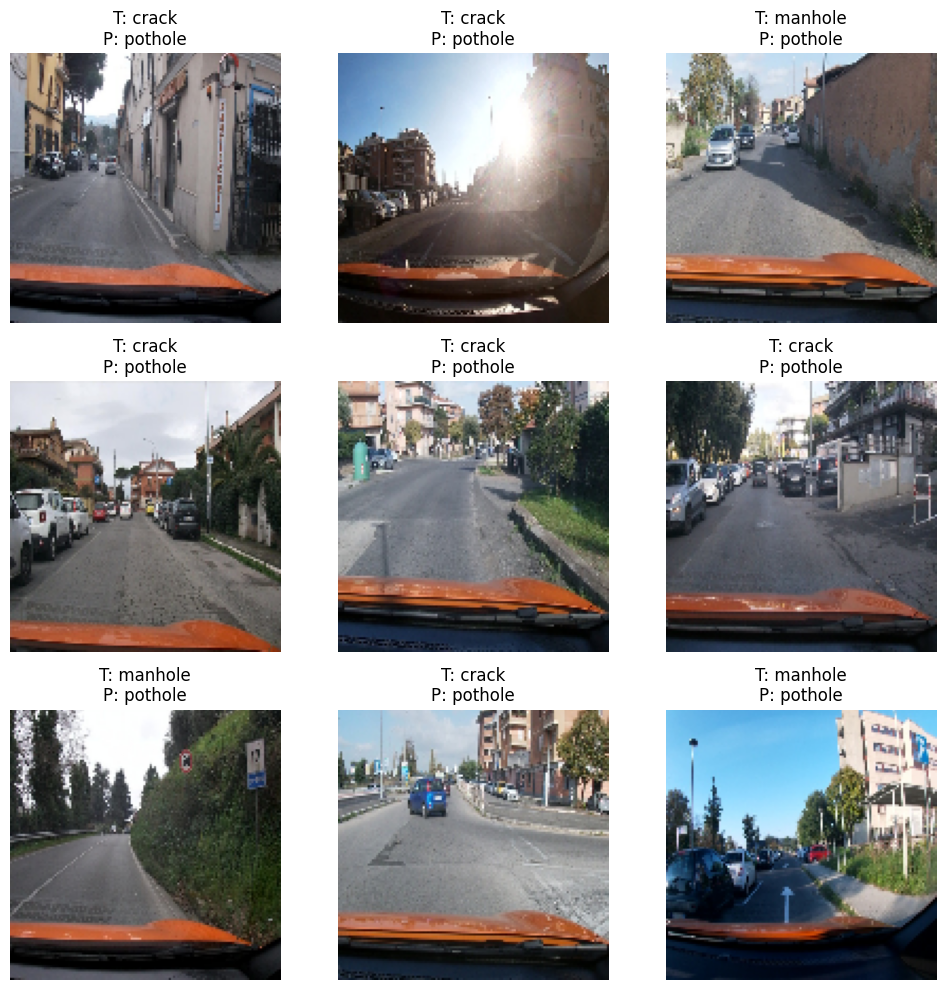

In [10]:
plt.figure(figsize=(10,10))
idxs = np.random.choice(len(X_test), 9, replace=False)

for i, idx in enumerate(idxs):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[idx])
    t = class_id_to_name[int(y_test[idx])]
    p = class_id_to_name[int(y_pred[idx])]
    plt.title(f"T: {t}\nP: {p}")
    plt.axis("off")

plt.tight_layout()
plt.show()


accuracy was low, so swifting to transfer learning.

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

input_shape = (128, 128, 3)
num_classes = 3

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_tensor=Input(shape=input_shape)
)

# Freeze initial layers (keeps training stable)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

callbacks = [
    ModelCheckpoint("best_mobileNet_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
]

history = model.fit(
    train_gen,
    steps_per_epoch=len(X_train) // 32,
    validation_data=(X_test, y_test),
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weight_dict
)


/tmp/ipython-input-1263873726.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 2,025,795 (7.73 MB)

 Non-trainable params: 396,544 (1.51 MB)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.3658 - loss: 1.3136
Epoch 1: val_accuracy improved from -inf to 0.30348, saving model to best_mobileNet_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 70s 823ms/step - accuracy: 0.3669 - loss: 1.3106 - val_accuracy: 0.3035 - val_loss: 6.2838 - learning_rate: 0.0010
Epoch 2/20
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5312 - loss: 0.9881

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.30348 to 0.30597, saving model to best_mobileNet_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5312 - loss: 0.9881 - val_accuracy: 0.3060 - val_loss: 6.2011 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4860 - loss: 1.0296
Epoch 3: val_accuracy improved from 0.30597 to 0.35323, saving model to best_mobileNet_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 0.4863 - loss: 1.0294 - val_accuracy: 0.3532 - val_loss: 2.3791 - learning_rate: 0.0010
Epoch 4/20
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5000 - loss: 0.9508
Epoch 4: val_accuracy did not improve from 0.35323
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5000 - loss: 0.9508 - val_accuracy: 0.3483 - val_loss: 2.3237 - learning_rate: 0.0010
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5763 - loss: 0.9216
Epoch 5: val_accuracy did not improve from 0.35323
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.5763 - loss: 0.9215 - val_accuracy: 0.2711 - val_loss: 2.6190 - learning_rate: 0.0010
Epoch 6/20
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.3750 - loss: 1.1766
Epoch 6: val_accuracy did not improve from 0.35323
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3750 - loss: 1.1766 - val_accuracy: 0.2736 - val_loss: 2.5485 - learning_rate: 0.0010
Epoch 7/20
50/50 ━━━━━━━━━━━━━


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.5876 - loss: 0.8771 - val_accuracy: 0.3731 - val_loss: 4.8354 - learning_rate: 0.0010
Epoch 8/20
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5000 - loss: 0.9512
Epoch 8: val_accuracy did not improve from 0.37313
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5000 - loss: 0.9512 - val_accuracy: 0.3607 - val_loss: 4.9848 - learning_rate: 5.0000e-04
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.6393 - loss: 0.7909
Epoch 9: val_accuracy improved from 0.37313 to 0.51741, saving model to best_mobileNet_model.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 0.6392 - loss: 0.7911 - val_accuracy: 0.5174 - val_loss: 1.6292 - learning_rate: 5.0000e-04
Epoch 10/20
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.6250 - loss: 0.7018
Epoch 10: val_accuracy did not improve from 0.51741
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6250 - loss: 0.7018 - val_accuracy: 0.5174 - val_loss: 1.5631 - learning_rate: 5.0000e-04
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.6572 - loss: 0.7285
Epoch 11: val_accuracy did not improve from 0.51741
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 129ms/step - accuracy: 0.6574 - loss: 0.7285 - val_accuracy: 0.4776 - val_loss: 2.1329 - learning_rate: 5.0000e-04
Epoch 12/20
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6250 - loss: 0.7271
Epoch 12: val_accuracy did not improve from 0.51741
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6250 - loss: 0.7271 - val_accuracy: 0.4876 - val_loss: 2.0736 - learning_rate: 5.0000e-04
Epoch 13/


Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.6998 - loss: 0.6662 - val_accuracy: 0.6144 - val_loss: 1.8098 - learning_rate: 5.0000e-04
Epoch 14/20
 1/50 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6875 - loss: 0.6390
Epoch 14: val_accuracy did not improve from 0.61443
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6875 - loss: 0.6390 - val_accuracy: 0.6144 - val_loss: 1.8161 - learning_rate: 2.5000e-04
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7472 - loss: 0.6006
Epoch 15: val_accuracy did not improve from 0.61443
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 0.7471 - loss: 0.6005 - val_accuracy: 0.6020 - val_loss: 1.7366 - learning_rate: 2.5000e-04


Still accuracy is low

In [12]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.0 MB/s eta 0:00:00


In [13]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path of your downloaded dataset
base_path = "/root/.cache/kagglehub/datasets/lorenzoarcioni/road-damage-dataset-potholes-cracks-and-manholes/versions/3/data"

images_dir = os.path.join(base_path, "images")
labels_dir = os.path.join(base_path, "labels")

# Create YOLO folder in Colab
yolo_base = "/content/road_damage_yolo"
os.makedirs(yolo_base, exist_ok=True)

# Create train/val folder structure
for sub in ["images/train", "images/val", "labels/train", "labels/val"]:
    os.makedirs(os.path.join(yolo_base, sub), exist_ok=True)

# List all images from the dataset
all_images = [f for f in os.listdir(images_dir) if f.endswith(".jpg")]

# Split into 80% train, 20% val
train_files, val_files = train_test_split(all_images, test_size=0.2, random_state=42)

# Copy images + labels into yolov8 structure
for split, file_list in [("train", train_files), ("val", val_files)]:
    for f in file_list:
        # Copy image
        shutil.copy(os.path.join(images_dir, f), os.path.join(yolo_base, f"images/{split}/{f}"))

        # Copy corresponding label
        label_file = f.replace(".jpg", ".txt")
        shutil.copy(os.path.join(labels_dir, label_file), os.path.join(yolo_base, f"labels/{split}/{label_file}"))

print("✔ YOLO dataset structure created successfully!")


✔ YOLO dataset structure created successfully!


In [14]:
yaml_content = """
train: /content/road_damage_yolo/images/train
val: /content/road_damage_yolo/images/val

nc: 3
names: ["pothole", "crack", "manhole"]
"""

with open("/content/road_damage_yolo/data.yaml", "w") as f:
    f.write(yaml_content)

print("data.yaml created!")


data.yaml created!


In [15]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")   # pretrained model

results = model.train(
    data="/content/road_damage_yolo/data.yaml",
    epochs=30,
    imgsz=640,
    batch=16
)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/road_damage_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, 

In [16]:
from ultralytics import YOLO
model = YOLO("yolov8m.pt")  # medium model, much stronger
model.train(
    data="/content/road_damage_yolo/data.yaml",
    epochs=40,
    imgsz=640,
    batch=8
)


Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/road_damage_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a948571a660>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

In [17]:
from ultralytics import YOLO

model = YOLO("/content/runs/detect/train2/weights/best.pt")


In [18]:
results = model.predict(
    source="/content/road_damage_yolo/images/val",
    save=True,
    imgsz=640
)



image 1/402 /content/road_damage_yolo/images/val/20250219_164746.jpg: 384x640 1 manhole, 117.6ms
image 2/402 /content/road_damage_yolo/images/val/20250219_164807.jpg: 384x640 3 potholes, 1 crack, 1 manhole, 36.0ms
image 3/402 /content/road_damage_yolo/images/val/20250219_164823.jpg: 384x640 1 pothole, 2 cracks, 25.1ms
image 4/402 /content/road_damage_yolo/images/val/20250219_165015.jpg: 384x640 1 pothole, 1 crack, 25.5ms
image 5/402 /content/road_damage_yolo/images/val/20250219_165056.jpg: 384x640 2 potholes, 27.2ms
image 6/402 /content/road_damage_yolo/images/val/20250219_165329.jpg: 384x640 2 potholes, 25.0ms
image 7/402 /content/road_damage_yolo/images/val/20250219_165339.jpg: 384x640 2 potholes, 25.1ms
image 8/402 /content/road_damage_yolo/images/val/20250219_165420.jpg: 384x640 1 pothole, 21.2ms
image 9/402 /content/road_damage_yolo/images/val/20250219_165424.jpg: 384x640 2 potholes, 21.3ms
image 10/402 /content/road_damage_yolo/images/val/20250219_165827.jpg: 384x640 1 pothole, 

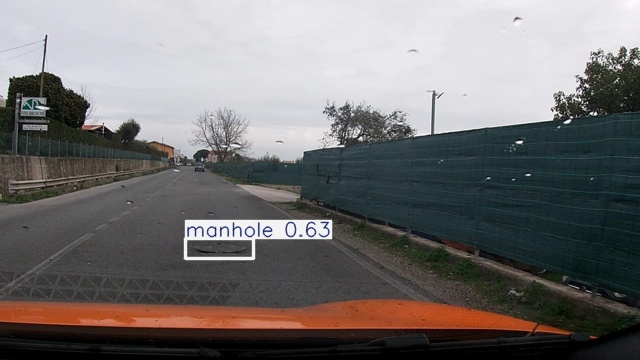

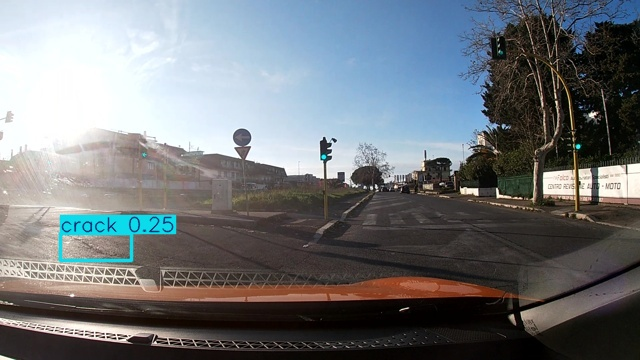

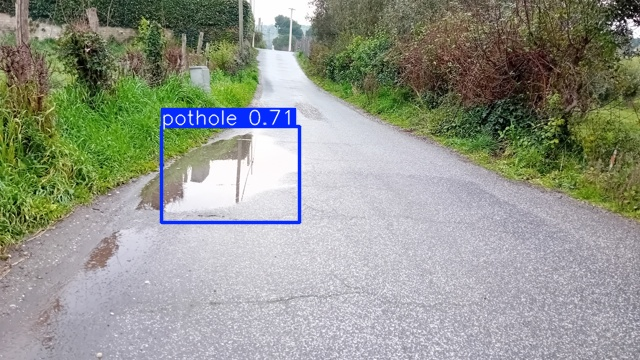

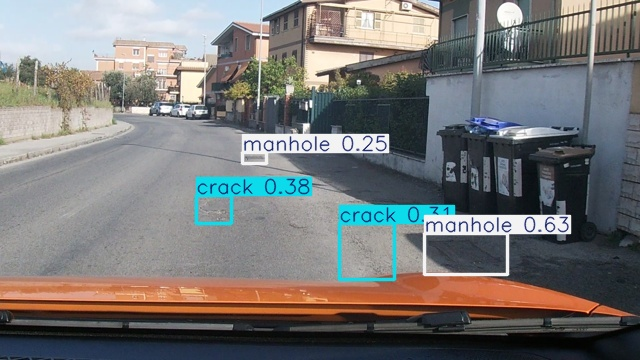

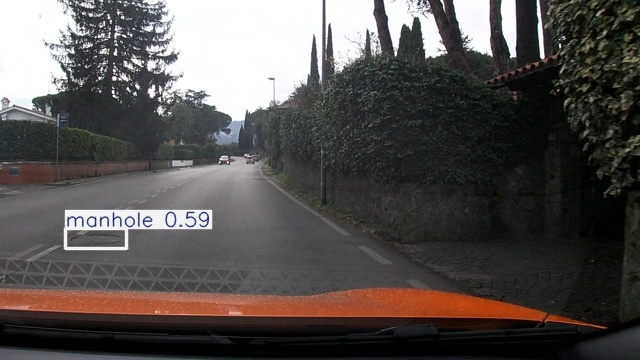

In [19]:
import glob, random
from IPython.display import Image, display

imgs = glob.glob("/content/runs/detect/predict/*.jpg")
for i in range(5):
    display(Image(random.choice(imgs)))
